In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('../task_2_dataset/london_weather_clean.csv')

# Show basic info on dataset
print(data.info())
print(data.describe())
print(data.columns)

# Handle missing data
data = data.dropna()

# Data to learn from
X = data.drop(columns=['mean_temp'])

# Target data to predict
y = data['mean_temp']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15104 entries, 0 to 15103
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15104 non-null  int64  
 1   cloud_cover       15085 non-null  float64
 2   sunshine          15104 non-null  float64
 3   global_radiation  15085 non-null  float64
 4   max_temp          15104 non-null  float64
 5   mean_temp         15075 non-null  float64
 6   min_temp          15104 non-null  float64
 7   precipitation     15102 non-null  float64
 8   pressure          15100 non-null  float64
 9   snow_depth        13672 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None
               date   cloud_cover      sunshine  global_radiation  \
count  1.510400e+04  15085.000000  15104.000000      15085.000000   
mean   1.999583e+07      5.247000      4.398649        119.978787   
std    1.211468e+05      2.070516      4.034056         88.883210

In [9]:
# Class for weather dataset for manipulation
class WeatherDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create training and testing datasets from main dataset
train_dataset = WeatherDataset(X_train_tensor, y_train_tensor)
test_dataset = WeatherDataset(X_test_tensor, y_test_tensor)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [10]:
import torch.nn as nn

# Define model
class PredictWeatherModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictWeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Init model
input_dim = X_train_tensor.shape[1]
model = PredictWeatherModel(input_dim)

In [11]:
import torch.optim as optim

# Loss + optimizer
# Mean squared error for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
#Training loop

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate Model
    # Validation
    model.eval()
    predictions=[]
    actuals=[]
    running_loss = 0.0
    with torch.no_grad():
        for X, y in test_loader:
            output = model(X)
            predictions.extend(output.cpu().numpy().flatten())
            actuals.extend(y.cpu().numpy().flatten())
            loss = criterion(output, y)
            running_loss += loss.item()
        val_loss = running_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}-RMSE: {rmse:.4f}-MAE: {mae:.4f}-R2: {r2:.4f}")






Epoch 1/10 - Training Loss: 0.9415 - Validation Loss: 0.0961-RMSE: 1.7499-MAE: 1.3821-R2: 0.9060
Epoch 2/10 - Training Loss: 0.0517 - Validation Loss: 0.0354-RMSE: 1.0642-MAE: 0.8246-R2: 0.9652
Epoch 3/10 - Training Loss: 0.0290 - Validation Loss: 0.0287-RMSE: 0.9563-MAE: 0.7453-R2: 0.9719
Epoch 4/10 - Training Loss: 0.0261 - Validation Loss: 0.0267-RMSE: 0.9223-MAE: 0.7150-R2: 0.9739
Epoch 5/10 - Training Loss: 0.0252 - Validation Loss: 0.0261-RMSE: 0.9112-MAE: 0.6989-R2: 0.9745
Epoch 6/10 - Training Loss: 0.0247 - Validation Loss: 0.0257-RMSE: 0.9025-MAE: 0.6965-R2: 0.9750
Epoch 7/10 - Training Loss: 0.0243 - Validation Loss: 0.0257-RMSE: 0.9020-MAE: 0.6975-R2: 0.9750
Epoch 8/10 - Training Loss: 0.0241 - Validation Loss: 0.0249-RMSE: 0.8874-MAE: 0.6825-R2: 0.9758
Epoch 9/10 - Training Loss: 0.0240 - Validation Loss: 0.0253-RMSE: 0.8950-MAE: 0.6859-R2: 0.9754
Epoch 10/10 - Training Loss: 0.0237 - Validation Loss: 0.0248-RMSE: 0.8868-MAE: 0.6796-R2: 0.9759



Final Model Performance:
Root Mean Square Error: 1.17°C
Mean Absolute Error: 0.92°C
R² Score: 0.9573

Sample Predictions vs Actual Values:
Predicted: 18.75°C, Actual: 19.10°C, Difference: -0.35°C
Predicted: 19.04°C, Actual: 19.10°C, Difference: -0.06°C
Predicted: 17.04°C, Actual: 16.80°C, Difference: 0.24°C
Predicted: 16.67°C, Actual: 17.10°C, Difference: -0.43°C
Predicted: 16.18°C, Actual: 16.00°C, Difference: 0.18°C

Error Statistics:
Average Error: -0.35°C
Standard Deviation of Error: 1.12°C
Maximum Overprediction: 9.14°C
Maximum Underprediction: -3.75°C


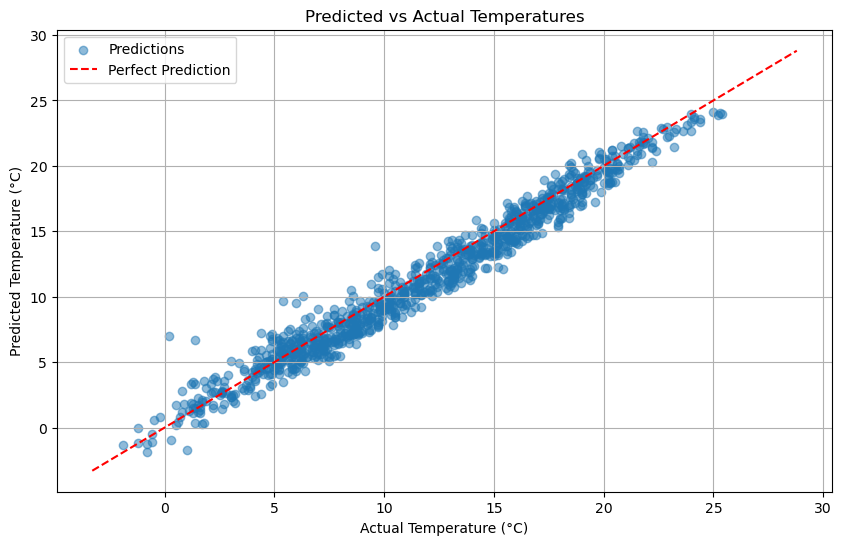

In [32]:
# After training loop completes, we'll make predictions
def make_predictions(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    actual_values = []

    # Make predictions without calculating gradients
    with torch.no_grad():
        for X, y in test_loader:
            # Get model's predictions for this batch
            outputs = model(X)
            # Store predictions and actual values
            all_predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(y.cpu().numpy().flatten())

    return np.array(all_predictions), np.array(actual_values)

# Make predictions using our trained model
predictions, actuals = make_predictions(model, test_loader)

# Let's analyze the predictions in detail
def analyze_predictions(predictions, actuals):
    # Calculate error metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print("\nFinal Model Performance:")
    print(f"Root Mean Square Error: {rmse:.2f}°C")
    print(f"Mean Absolute Error: {mae:.2f}°C")
    print(f"R² Score: {r2:.4f}")

    # Show some example predictions
    print("\nSample Predictions vs Actual Values:")
    for i in range(5):  # Show first 5 predictions
        print(f"Predicted: {predictions[i]:.2f}°C, Actual: {actuals[i]:.2f}°C, "
              f"Difference: {(predictions[i] - actuals[i]):.2f}°C")

    # Calculate prediction error statistics
    errors = predictions - actuals
    print(f"\nError Statistics:")
    print(f"Average Error: {np.mean(errors):.2f}°C")
    print(f"Standard Deviation of Error: {np.std(errors):.2f}°C")
    print(f"Maximum Overprediction: {np.max(errors):.2f}°C")
    print(f"Maximum Underprediction: {np.min(errors):.2f}°C")

# Analyze our predictions
analyze_predictions(predictions, actuals)

# We can also visualize the predictions vs actual values
import matplotlib.pyplot as plt

def plot_predictions(predictions, actuals, num_points=1000):
    plt.figure(figsize=(10, 6))

    # Plot the first num_points predictions
    plt.scatter(actuals[:num_points], predictions[:num_points],
                alpha=0.5, label='Predictions')

    # Plot perfect prediction line
    min_val = min(min(predictions), min(actuals))
    max_val = max(max(predictions), max(actuals))
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='Perfect Prediction')

    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize our predictions
plot_predictions(predictions, actuals)

In [ ]:
# Improve model
# implement dropout,add more layers,batch normalisation
class BetterSequentialWeatherModel(nn.Module):
   def __init__(self, input_dim=8, sequence_length=7):
       super(BetterSequentialWeatherModel, self).__init__()

       # Simpler but effective LSTM
       self.lstm = nn.LSTM(
           input_size=input_dim,
           hidden_size=128,
           num_layers=4,     # Reduced complexity
           batch_first=True,
           dropout=0.1       # Reduced dropout
       )

       # Simple but effective prediction layers
       self.predictor = nn.Sequential(
           nn.Linear(128, 64),
           nn.ReLU(),
           nn.Dropout(0.1),
           nn.Linear(64, 1)
       )

   def forward(self, x):
       # Process through LSTM
       lstm_out, _ = self.lstm(x)
       # Take the final time step's output
       final_hidden = lstm_out[:, -1, :]
       # Make prediction
       return self.predictor(final_hidden)

def train_sequential_model(data, sequence_length=5):  # Reduced sequence length
   # Prepare sequences
   X_sequences, y_sequences = prepare_weather_sequences(data, sequence_length)

   # Standardize the input features
   scaler = StandardScaler()
   # Reshape for scaling
   original_shape = X_sequences.shape
   X_reshaped = X_sequences.reshape(-1, X_sequences.shape[-1])
   X_scaled = scaler.fit_transform(X_reshaped)
   X_sequences = X_scaled.reshape(original_shape)

   # Split data
   train_size = int(0.8 * len(X_sequences))
   X_train = X_sequences[:train_size]
   X_test = X_sequences[train_size:]
   y_train = y_sequences[:train_size]
   y_test = y_sequences[train_size:]

   # Convert to tensors
   X_train_tensor = torch.FloatTensor(X_train)
   y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
   X_test_tensor = torch.FloatTensor(X_test)
   y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

   # Create data loaders
   train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
   test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
   train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
   test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

   # Initialize model and training components
   model = BetterSequentialWeatherModel(input_dim=X_train.shape[2])
   criterion = nn.MSELoss()
   optimizer = optim.Adam(model.parameters(), lr=0.001)

   # Training loop
   num_epochs = 10
   best_r2 = float('-inf')
   patience = 3
   patience_counter = 0

   for epoch in range(num_epochs):
       # Training phase
       model.train()
       running_loss = 0.0
       for X, y in train_loader:
           optimizer.zero_grad()
           outputs = model(X)
           loss = criterion(outputs, y)
           loss.backward()
           optimizer.step()
           running_loss += loss.item()

       train_loss = running_loss / len(train_loader.dataset)

       # Evaluation phase
       model.eval()
       predictions = []
       actuals = []
       val_loss = 0.0

       with torch.no_grad():
           for X, y in test_loader:
               outputs = model(X)
               predictions.extend(outputs.cpu().numpy().flatten())
               actuals.extend(y.cpu().numpy().flatten())
               loss = criterion(outputs, y)
               val_loss += loss.item()

       # Calculate metrics
       val_loss = val_loss / len(test_loader.dataset)
       mse = mean_squared_error(actuals, predictions)
       rmse = np.sqrt(mse)
       mae = mean_absolute_error(actuals, predictions)
       r2 = r2_score(actuals, predictions)

       print(f"Epoch {epoch+1}/{num_epochs}")
       print(f"Training Loss: {train_loss:.4f}")
       print(f"Validation Loss: {val_loss:.4f}")
       print(f"RMSE: {rmse:.4f}°C")
       print(f"MAE: {mae:.4f}°C")
       print(f"R² Score: {r2:.4f}\n")

       # Early stopping check
       if r2 > best_r2:
           best_r2 = r2
           patience_counter = 0
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print("Early stopping triggered")
               break

   return model, train_loader, test_loader

# Train the model
model, train_loader, test_loader = train_sequential_model(data)

In [33]:
def make_weather_predictions(model, test_loader):
    """
    Makes predictions using our trained weather model and analyzes its performance.
    """
    model.eval()
    predictions = []
    actual_values = []

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(y.cpu().numpy().flatten())

    predictions = np.array(predictions)
    actual_values = np.array(actual_values)

    # Calculate performance metrics
    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predictions)
    r2 = r2_score(actual_values, predictions)

    print("\nFinal Model Performance:")
    print(f"RMSE: {rmse:.2f}°C")
    print(f"MAE: {mae:.2f}°C")
    print(f"R² Score: {r2:.4f}")

    return predictions, actual_values


Final Model Performance:
RMSE: 1.17°C
MAE: 0.92°C
R² Score: 0.9573


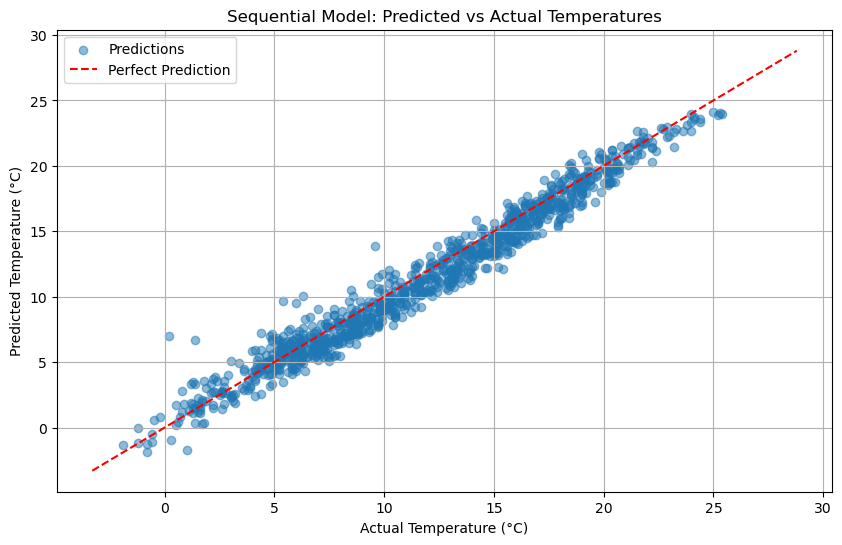

In [34]:

def plot_prediction_results(predictions, actuals, num_points=1000):
    plt.figure(figsize=(10, 6))

    # Create scatter plot

    plt.scatter(actuals[:num_points], predictions[:num_points], alpha=0.5,label='Predictions')

    # Add perfect prediction line
    min_temp = min(min(predictions), min(actuals))
    max_temp = max(max(predictions), max(actuals))
    plt.plot([min_temp, max_temp], [min_temp, max_temp],
             'r--', label='Perfect Prediction')

    # Add title and labels
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Sequential Model: Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

# Now we can visualize
predictions, actuals = make_weather_predictions(model, test_loader)
plot_prediction_results(predictions, actuals)




In [13]:
# Hyperparameter optimization